Using device:  cuda


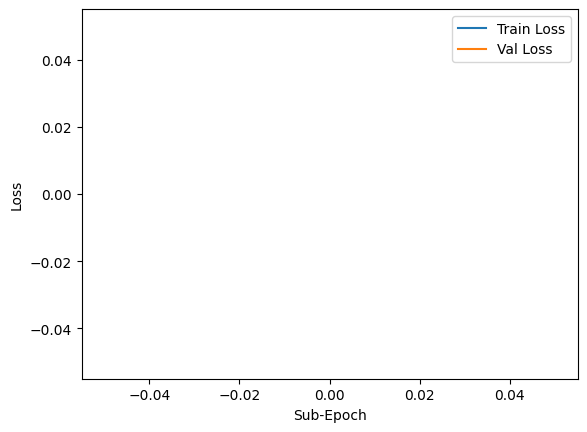

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from torch.utils.data import DataLoader, Dataset, random_split
from lib.checkpoint import load_checkpoint, save_checkpoint
from lib.image import load_encoded_data
from lib.binvox import load_voxel_file
from lib.config import *
from lib.autoencoder import *
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

import time

In [ ]:
LSTM_NEUROES = ENCODED_TENSOR_SIZE


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=LSTM_NEUROES, hidden_size=LSTM_NEUROES, num_layers=2, output_size=LSTM_NEUROES):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.input_fc = nn.Linear(input_size + output_size, input_size)  # 映射到 input_size

    def forward(self, input_t, prev_output, h_0, c_0):
        if prev_output is not None:
            input_t = torch.cat((input_t, prev_output), dim=1)
            input_t = self.input_fc(input_t)  # 映射到原始input_size

        input_t = input_t.unsqueeze(1)  # 调整形状为 (batch_size, seq_len, input_size)
        out, (h_0, c_0) = self.lstm(input_t, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out, h_0, c_0
        



In [ ]:
class CTNN3DDecoder(nn.Module):
    def __init__(self):
        super(CTNN3DDecoder, self).__init__()
        self.fc = nn.Linear(LSTM_NEUROES, 8*8*8*16)  # 假設 LSTM_NEUROES 是可變的
        
        self.conv1 = nn.ConvTranspose3d(in_channels=16, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout3d(p=0.2)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.conv2 = nn.ConvTranspose3d(in_channels=12, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout3d(p=0.2)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.conv3 = nn.ConvTranspose3d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout3d(p=0.2)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.conv4 = nn.ConvTranspose3d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout3d(p=0.2)
        self.upsample4 = nn.Upsample(size=(32, 32, 32), mode='nearest')
        
    def forward(self, x):
        out = self.fc(x)
        out = out.view(1, 16, 8, 8, 8)
        
        out = self.conv1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.upsample1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.upsample2(out)
        
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.upsample3(out)
        
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        out = self.upsample4(out)
        print(out.shape)
        return out

model = CTNN3DDecoder()
test = torch.randn(LSTM_NEUROES)
model(test)
# # print model in ram size
# print('Model size:', sum(p.numel() for p in model.parameters()))


In [ ]:
class LSTMDecoder(nn.Module):
    def __init__(self):
        super(LSTMDecoder, self).__init__()
        self.lstm = LSTM()
        self.decoder = CTNN3DDecoder()
        
    def forward(self, x, prev_output, h_0, c_0):
        prev_out, h_0, c_0 = self.lstm(x, prev_output, h_0, c_0)
        out = self.decoder(prev_out)
        return out, prev_out, h_0, c_0


In [ ]:
class TrainDataset(Dataset):
    def __init__(self, datas, voxel):
        self.datas = datas
        self.voxel = voxel

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, index):
        return self.datas[index], self.voxel[index].astype(np.float32)

In [ ]:
def train_sub_epoch(epoch, datas, model, criterion, optimizer, device):
    data_len = len(datas)
    train_data, val_data = random_split(datas, [int(data_len * 0.8), data_len - int(data_len * 0.8)])
    print("Epoch:{} Train Size:{} Val Size:{}".format(epoch, len(train_data), len(val_data)))

    train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=1, shuffle=True)
    train_logs = []
    val_logs = []
    # move data and model to device
    model.to(device)
    criterion.to(device)
    seq_len = 1
    start = time.time()
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        batch_size = inputs.size(0)
        h_0 = torch.zeros(model.lstm.num_layers, batch_size, model.lstm.hidden_size).to(inputs.device)
        c_0 = torch.zeros(model.lstm.num_layers, batch_size, model.lstm.hidden_size).to(inputs.device)
        prev_output = None

        inputs = inputs.view(batch_size, seq_len, -1)
        for t in range(seq_len):
            input_t = inputs[:, t]
            decode_output, prev_output, h_0, c_0 = model(input_t, prev_output, h_0, c_0)
        
        test_chennal = decode_output[:, 0]
        loss = criterion(test_chennal , targets)
        loss.backward()
        optimizer.step()
        train_logs.append(loss.item())

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            batch_size = inputs.size(0)
            h_0 = torch.zeros(model.lstm.num_layers, batch_size, model.lstm.hidden_size).to(inputs.device)
            c_0 = torch.zeros(model.lstm.num_layers, batch_size, model.lstm.hidden_size).to(inputs.device)
            prev_output = None

            inputs = inputs.view(batch_size, seq_len, -1)
            for t in range(seq_len):
                input_t = inputs[:, t]
                decode_output, prev_output, h_0, c_0 = model(input_t, prev_output, h_0, c_0)
        
            test_chennal = decode_output[:, 0]
            loss = criterion(test_chennal , targets)
            val_logs.append(loss.item())
            
    end = time.time()

    print("Epoch:{} Sub Train Time:{:.2f} Train Loss:{:.4f} Val Loss:{:.4f}".format(epoch, end - start,
                                                                                    sum(train_logs) / len(train_logs),
                                                                                    sum(val_logs) / len(val_logs)))
    return sum(train_logs) / len(train_logs), sum(val_logs) / len(val_logs)


In [ ]:
def run_training(file_path, device, checkpoint_path):
    model = LSTMDecoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    early_stopping = EarlyStopping(patience=5, min_delta=0.0001)
    epoch_losses = []
    num_epochs = 20
    
    start_epoch, epoch_losses, last_folder, train_loss, val_loss = load_checkpoint(checkpoint_path, model, optimizer, device)

    model.train()
    for epoch in range(start_epoch, num_epochs):
        start = time.time()
        cnt = 0
        train_loss = []
        val_loss = []
        resume = (last_folder is not None)
        skip_cnt = 0
        renders = []
        voxels = []
        for root, dirs, files in os.walk("dataset/"):
            folder = root.split("/")[-1]
            if(resume):
                if(folder == last_folder):
                    print("Resume from {}, Skip {} Files".format(folder, skip_cnt))
                    resume = False
                else:
                    skip_cnt += 1
                    continue
            start_io = time.time()
            if(folder == ""): continue
            print(root) # print current folder
            render = load_encoded_data(root)
            voxel = load_voxel_file(root + "/voxel.txt")
            voxel.reshape(32, 32, 32)
            if render is None or voxel is None:
                continue             
            for i in render:
                renders.append(i)
                voxels.append(voxel)
            cnt += 1
            if(cnt >= 10):
                end_io = time.time()
                print("IO Time:{:.2f}".format(end_io-start_io))
                dataset = TrainDataset(renders, voxels)
                train, val = train_sub_epoch(epoch, dataset, model, criterion, optimizer, device)
                train_loss.append(train)
                val_loss.append(val)
                renders = []
                voxels = []
                cnt = 0
                start_io = time.time()
                save_checkpoint({
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch_losses': epoch_losses,
                    'last_file': folder,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, filename = checkpoint_path)
        if(cnt > 0):
            dataset = TrainDataset(renders, voxels)
            train, val = train_sub_epoch(epoch, dataset, model, criterion, optimizer, device)
            train_loss.append(train)
            val_loss.append(val)
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch_losses': epoch_losses,
                'last_file': None,
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, filename = checkpoint_path)
        end = time.time()
        epoch_train_loss = sum(train_loss)/len(train_loss)
        epoch_val_loss = sum(val_loss)/len(val_loss)
        epoch_losses.append((epoch_train_loss, epoch_val_loss))
        print("Epoch:{} Time:{:.2f} Train Loss:{:.4f} Val Loss:{:.4f}".format(epoch, end-start, epoch_train_loss, epoch_val_loss))
        if early_stopping(epoch_val_loss):
            print("Early Stopping at Epoch:{}".format(epoch))
            break
    return model, epoch_losses

In [ ]:
def train_lstmdecoder(device, dataset_path = DEFAULT_ENCODED_DATASET_FOLDER, checkpoint_path = DEFAULT_LSTMDECODER_FILE):
    model, epoch_losses = run_training(dataset_path, device, checkpoint_path)
    model.eval()
    torch.save(model.state_dict(), "model/lstmdecoder.pth")
    torch.save(model.lstm.state_dict(), "model/lstm.pth")
    torch.save(model.decoder.state_dict(), "model/ctnn3d.pth")
    return model, epoch_losses

In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, epoch_losses = train_lstmdecoder(device)
    print(epoch_losses)
    

In [ ]:
# 初始化模型
model = LSTM()
batch_size = 1

# 初始化隐藏层状态
h_0 = torch.zeros(model.num_layers, batch_size, model.hidden_size)
c_0 = torch.zeros(model.num_layers, batch_size, model.hidden_size)

# 第一次输入
input_1 = torch.randn(batch_size, 1, LSTM_NEUROES)  # (batch_size, seq_len, input_size)
print(input_1.shape)
output, h_n, c_n = model(input_1, None, h_0, c_0)
print("第一次输出:", output)

# 第二次输入，使用第一次的输出作为一部分输入
input_2 = torch.randn(batch_size, 1, LSTM_NEUROES)  # 另外的输入
new_input = torch.cat((input_2, output.unsqueeze(1)), dim=2)  # 合并输出作为输入的一部分
new_input = model.input_fc(new_input)  # 映射到原始input_size

output, h_n, c_n = model(new_input, h_n, c_n)
print("第二次输出:", output)

# 多次迭代输入进行修正
num_iterations = 5
for i in range(num_iterations):
    input_next = torch.randn(batch_size, 1, LSTM_NEUROES)  # 另外的输入
    new_input = torch.cat((input_next, output.unsqueeze(1)), dim=2)  # 合并输出作为输入的一部分
    new_input = model.input_fc(new_input)  # 映射到原始input_size

    output, h_n, c_n = model(new_input, h_n, c_n)
    print(f"第{i+3}次输出:", output)